In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# load PC coords
project_dir = '/data/2Dshapespace/B2AI/'
#project_dir = '/data/2Dshapespace/S-BIAD34/'
shape_mode_path = f'{project_dir}/shapemode/fft_cell_major_axis_polarized_cell_nuclei'
#scatter_hist(df_trans["PC1"], df_trans["PC2"], labels, save_path=f"{shape_mode_path}/PC1vsPC2_scatter_hist.png")
df_trans = pd.read_csv(f'{shape_mode_path}/transformed_matrix.csv', index_col=0)

# Load sc stats measurement
sc_stats = pd.read_csv(f'{project_dir}/single_cell_statistics_pcs.csv')
sc_stats['Protein_cell_mean'] = sc_stats.Protein_cell_sum/sc_stats.cell_area
#thres = np.percentile(sc_stats[sc_stats.image_path.str.contains('NEGATIVE_CTRL')].Protein_cell_mean, 99)
thres = np.max(sc_stats[sc_stats.image_path.str.contains('NEGATIVE_CTRL')].Protein_cell_mean)
cells_to_keep = sc_stats[(sc_stats.cell_nu_ratio <= 8) & (sc_stats.Protein_cell_mean > thres)].image_path

In [2]:
df_trans = df_trans[df_trans.index.isin(cells_to_keep)]
labels = np.array([f.split('_')[-3] if 'NEGATIVE_CTRL' not in f else 'NEGATIVE_CTRL' for f in df_trans.index])

<Axes: xlabel='PC1', ylabel='PC2'>

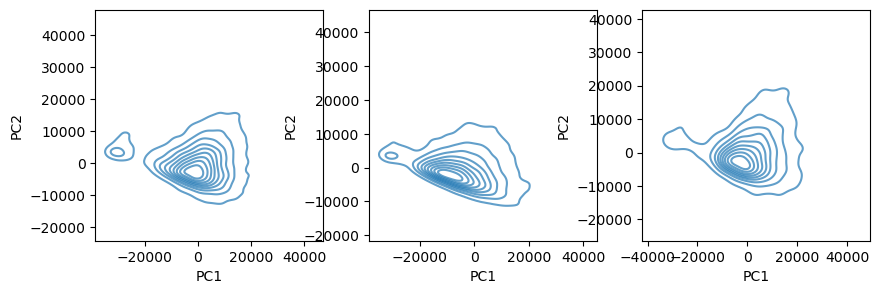

In [3]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
sns.kdeplot(x=df_trans.PC1[labels == 'untreated'], y=df_trans.PC2[labels == 'untreated'], fill=False, alpha=0.7, thresh=0.05, ax=ax[0])
sns.kdeplot(x=df_trans.PC1[labels == 'Paclitaxel'], y=df_trans.PC2[labels == 'Paclitaxel'], fill=False, alpha=0.7, thresh=0.05, ax=ax[1])
sns.kdeplot(x=df_trans.PC1[labels == 'Vorinostat'], y=df_trans.PC2[labels == 'Vorinostat'], fill=False, alpha=0.7, thresh=0.05, ax=ax[2])

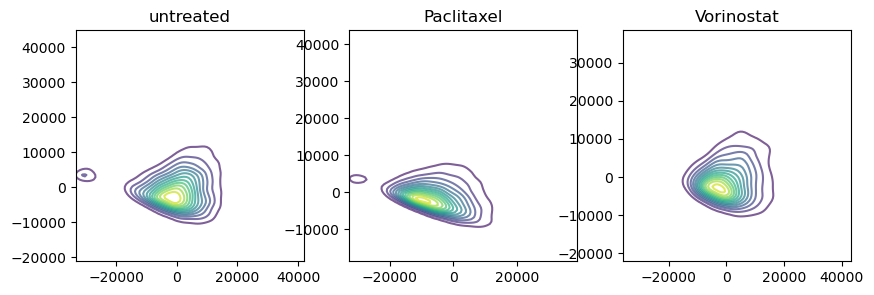

In [4]:
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

labels_list = ['untreated', 'Paclitaxel', 'Vorinostat']
for i, label in enumerate(labels_list):
    x = df_trans.PC1[labels == label]
    y = df_trans.PC2[labels == label]
    
    # Perform kernel density estimation
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    
    # Create grid for density plot
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
    
    # Contour plot
    ax[i].contour(xx, yy, zz, levels=15, alpha=0.7)
    ax[i].set_title(label)

plt.show()

In [5]:
def filter_percentile(x, low, high):
    xmin, xmax = np.percentile(x, low), np.percentile(x, high)
    return x[(x >= xmin) & (x <= xmax)]

import matplotlib.gridspec as gridspec
from scipy.stats import norm
colors = [
        "#000000",
        "#3f51b5",
        "#f44336",
        "#3226fd",
    ]
def plot_kde_hist(x, y, label, n_bin=20, save_path='tmp.png'):
    label = np.asarray(labels)

    unique_labels = set(label) #['untreated','Vorinostat','Paclitaxel'] #set(label)
    cell_lines = "B2AI"

    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    #ax_main.set_xlim([xmin, xmax])
    #ax_main.set_ylim([ymin, ymax])
    ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    for i, i_ in enumerate(unique_labels):
        print(i, i_)
        # Plot data histogram and Fitting a normal distribution to the data
        class_data_x = np.array(x[label == i_])
        class_data_x = filter_percentile(class_data_x, 1, 99)
        ax_xDist.hist(class_data_x, bins=n_bin, density=True, color=colors[i], alpha=0.2, label=i_)        
        mu, std = norm.fit(class_data_x)
        #xmin, xmax = np.percentile(x, 1), np.percentile(x, 99)
        xmin, xmax = np.min(x), np.max(x) # ax_xDist.get_xlim()
        x_range = np.linspace(xmin, xmax, 1000)
        fitted_line = norm.pdf(x_range, mu, std) #* len(class_data_x)
        ax_xDist.plot(x_range, fitted_line, color=colors[i], linewidth=2)

        # Plot data histogram and Fitting a normal distribution to the data
        class_data_y = np.array(y[label == i_])
        class_data_y = filter_percentile(class_data_y, 1, 99)
        ax_yDist.hist(class_data_y, bins=n_bin, density=True, color=colors[i], alpha=0.2, label=i_, orientation='horizontal')    

        mu, std = norm.fit(class_data_y)
        xmin, xmax = np.min(y), np.max(y) # ax_yDist.get_xlim()
        y_range = np.linspace(xmin, xmax, 1000)
        fitted_line = norm.pdf(y_range, mu, std) #* len(class_data_y)
        ax_yDist.plot(fitted_line, y_range, color=colors[i], linewidth=2) 

        # Main scatter plot
        #ax_main.scatter(class_data_x, class_data_y,marker='.', color=colors[i], alpha=0.01)
        sns.kdeplot(x=class_data_x, y=class_data_y, ax=ax_main, color=colors[i], fill=True, alpha=0.4, thresh=0.05)

    ax_main.set(xlabel="PC1", ylabel="PC4")
    #ax_yDist.legend()
    ax_xDist.legend(bbox_to_anchor=(1,1), loc="upper left", framealpha=0)
    plt.savefig(save_path, transparent=True)

#plot_kde_hist(x = df_trans["PC1"], y = df_trans["PC4"], label=label)

0 Paclitaxel


1 untreated
2 Vorinostat


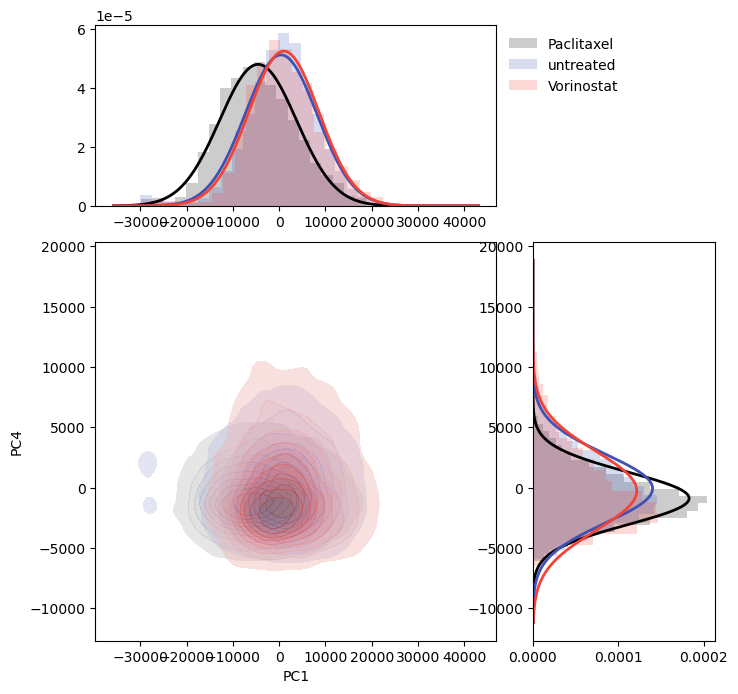

In [6]:
labels = [f.split('_')[-3] if 'NEGATIVE_CTRL' not in f else 'NEGATIVE_CTRL' for f in df_trans.index]
plot_kde_hist(x = df_trans["PC1"], y = df_trans["PC4"], label=labels, save_path=f'{project_dir}/plots/PC1vsPC4.png')

In [7]:
labels == 'untreated'

False

0 untreated
(15164,)
1 Vorinostat
(4575,)
2 Paclitaxel
(10365,)


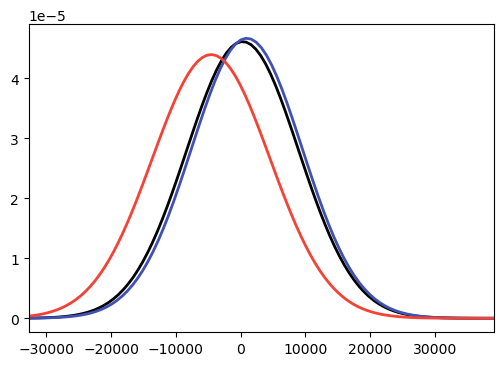

In [8]:

plt.figure(figsize=(6,4))

for i, i_ in enumerate(['untreated','Vorinostat','Paclitaxel']):
    print(i, i_)
    # Plot data histogram and Fitting a normal distribution to the data
    class_data_x = np.array(df_trans["PC1"][np.asarray(labels) == i_])
    print(class_data_x.shape)
    #class_data_x = filter_percentile(class_data_x, 1, 99)
    #print(class_data_x.shape)
    mu, std = norm.fit(class_data_x)
    xmin, xmax = np.min(class_data_x), np.max(class_data_x) # ax_yDist.get_xlim()
    x_range = np.linspace(xmin, xmax, 100)
    fitted_line = norm.pdf(x_range, mu, std) #* len(class_data_y)
    plt.plot(x_range, fitted_line, color=colors[i], linewidth=2) 
    plt.xlim(xmin, xmax)



In [9]:
# Wasserstein distance of shape distribution of untreated vs treated cells
from scipy.stats import wasserstein_distance

df_trans['Protein'] = [f.split('/')[-3] for f in df_trans.index]
df_trans['treatment'] = labels

In [10]:
df_trans

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC1017,PC1018,PC1019,PC1020,PC1021,PC1022,PC1023,PC1024,Protein,treatment
/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080431_HDAC7/B2AI_1_untreated_H3_R3/3.npy,-21882.083427,3014.910110,-572.971016,131.855766,676.115403,5.762324,-78.501655,407.878983,0,0,...,0,0,0,0,0,0,0,0,CAB080431_HDAC7,untreated
/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080431_HDAC7/B2AI_1_Paclitaxel_H3_R7/1.npy,6271.735610,-6936.263224,-2251.466271,-4770.263105,-192.903611,947.907327,-1657.327730,1949.448473,0,0,...,0,0,0,0,0,0,0,0,CAB080431_HDAC7,Paclitaxel
/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080431_HDAC7/B2AI_1_untreated_H3_R8/2.npy,-1605.739990,2301.090394,6397.000216,3894.437676,3780.798462,-121.823466,921.812802,-218.065085,0,0,...,0,0,0,0,0,0,0,0,CAB080431_HDAC7,untreated
/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080431_HDAC7/B2AI_1_untreated_H3_R8/6.npy,8795.873520,3256.374561,5677.583317,3565.284665,963.574491,2673.771976,-893.351988,1364.154589,0,0,...,0,0,0,0,0,0,0,0,CAB080431_HDAC7,untreated
/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080431_HDAC7/B2AI_1_untreated_H3_R8/1.npy,9188.601323,-571.767868,-5968.402948,8663.713702,-221.608554,2150.806465,-2972.070968,-1326.927716,0,0,...,0,0,0,0,0,0,0,0,CAB080431_HDAC7,untreated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA030991_HDAC5/B2AI_1_untreated_F3_R3/28.npy,-4229.843897,5311.858239,2939.576290,-3667.391576,3.236076,1715.725986,210.352799,-383.685857,0,0,...,0,0,0,0,0,0,0,0,HPA030991_HDAC5,untreated
/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA030991_HDAC5/B2AI_1_untreated_F3_R3/9.npy,775.637727,-6586.685458,-5491.908080,-1465.142415,1867.048695,3296.069036,-720.200294,-640.502486,0,0,...,0,0,0,0,0,0,0,0,HPA030991_HDAC5,untreated
/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA030991_HDAC5/B2AI_1_untreated_F3_R3/18.npy,12607.505711,-1896.500518,4906.537739,3949.271573,-401.969455,-694.850373,-1068.265478,1049.891614,0,0,...,0,0,0,0,0,0,0,0,HPA030991_HDAC5,untreated
/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA030991_HDAC5/B2AI_1_untreated_F3_R3/23.npy,144.099352,2110.787510,6019.701704,-4646.380504,652.969721,951.101101,-172.939938,-639.435149,0,0,...,0,0,0,0,0,0,0,0,HPA030991_HDAC5,untreated


In [11]:
df_trans.PC1.median(), df_trans.PC1.std()

(-909.2578640180051, 9104.72387176193)

In [12]:
def cal_pdf(x):
    '''
    x = filter_percentile(x, 1, 99)
    mu, std = norm.fit(x)
    xmin, xmax = np.min(x), np.max(x)
    x_range = np.linspace(xmin, xmax, 50)
    return norm.pdf(x_range, mu, std)
    '''
    x = filter_percentile(x, 1, 99)
    kde = gaussian_kde(x)
    x_values = np.linspace(min(x), max(x), 100)
    pdf_values = kde(x_values)
    return pdf_values
    
df_trans['PC1_zscore'] = (df_trans.PC1 - df_trans.PC1.mean()) / df_trans.PC1.std()
results = []

for p, df_trans_ in df_trans.groupby('Protein'):
    a = cal_pdf(df_trans_['PC1_zscore'][df_trans_['treatment'] == 'untreated'])
    b = cal_pdf(df_trans_['PC1_zscore'][df_trans_['treatment'] == 'Paclitaxel'])
    paclitaxel_untreated = wasserstein_distance(a, b)
    
    b = cal_pdf(df_trans_['PC1_zscore'][df_trans_['treatment'] == 'Vorinostat'])
    vorinostat_untreated = wasserstein_distance(a, b)
    results.append([p, 
                    df_trans_['PC1_zscore'][df_trans_['treatment'] == 'untreated'].shape[0],
                    df_trans_['PC1_zscore'][df_trans_['treatment'] == 'Paclitaxel'].shape[0],
                    df_trans_['PC1_zscore'][df_trans_['treatment'] == 'Vorinostat'].shape[0],
                    paclitaxel_untreated,
                    vorinostat_untreated]
                   )
results = pd.DataFrame(results, columns=['Protein', 'untreated', 'Paclitaxel', 'Vorinostat', 'Paclitaxel_untreated', 'Vorinostat_untreated'])
results.sort_values('Paclitaxel_untreated')

,Protein,untreated,Paclitaxel,Vorinostat,Paclitaxel_untreated,Vorinostat_untreated
2,CAB080425_KAT2A,177,123,60,0.014299,0.135499
74,HPA055861_KAT3A,208,116,43,0.018883,0.043118
1,CAB079921_PPP1CC,213,165,33,0.022483,0.193724
45,HPA029069_BPTF,132,61,40,0.025885,0.051828
91,HPA074736_KMT2C,182,158,58,0.026684,0.081241
...,...,...,...,...,...,...
53,HPA038244_KDM5C,210,34,35,0.133710,0.021000
56,HPA043837_PPP4C,22,74,38,0.136376,0.061262
60,HPA044910_KMT2A,196,119,39,0.141824,0.244575
90,HPA072136_PRMT1,107,99,76,0.158564,0.156859


In [13]:

a = cal_pdf(df_trans['PC1_zscore'][df_trans['treatment'] == 'untreated'])
b = cal_pdf(df_trans['PC1_zscore'][df_trans['treatment'] == 'Paclitaxel'])
paclitaxel_untreated = wasserstein_distance(a, b)
print(f'WD untreated-Paclitaxel: {paclitaxel_untreated:.2f}')

b = cal_pdf(df_trans['PC1'][df_trans['treatment'] == 'Vorinostat'])
vorinostat_untreated = wasserstein_distance(a, b)
print(f'WD untreated-Vorinostat: {vorinostat_untreated:.2f}')

WD untreated-Paclitaxel: 0.03
WD untreated-Vorinostat: 0.18


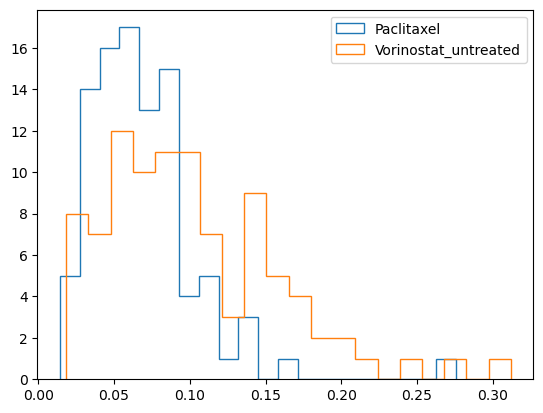

In [14]:
plt.hist(results.Paclitaxel_untreated, bins = 20, histtype='step', stacked=True, label='Paclitaxel')
plt.hist(results.Vorinostat_untreated, bins = 20, histtype='step', stacked=True, label='Vorinostat_untreated')
plt.legend()

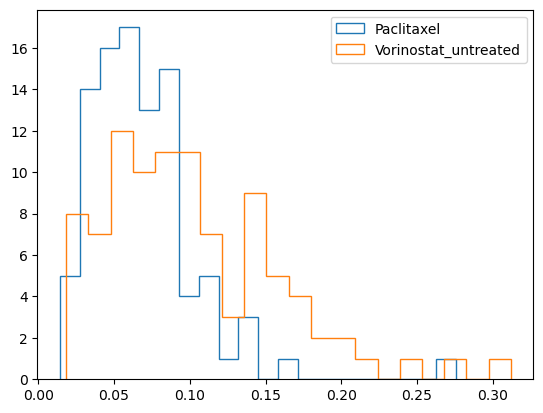

In [15]:
plt.hist(results.Paclitaxel_untreated, bins = 20, histtype='step', stacked=True, label='Paclitaxel')
plt.hist(results.Vorinostat_untreated, bins = 20, histtype='step', stacked=True,  label='Vorinostat_untreated')
plt.legend()

In [16]:
# sc_stats[sc_stats.image_path.isin(df_trans[df_trans.PC1 <=-28000].index)]

In [17]:
sum(sc_stats.cell_nu_ratio <= 1)

872

0 Paclitaxel


1 untreated


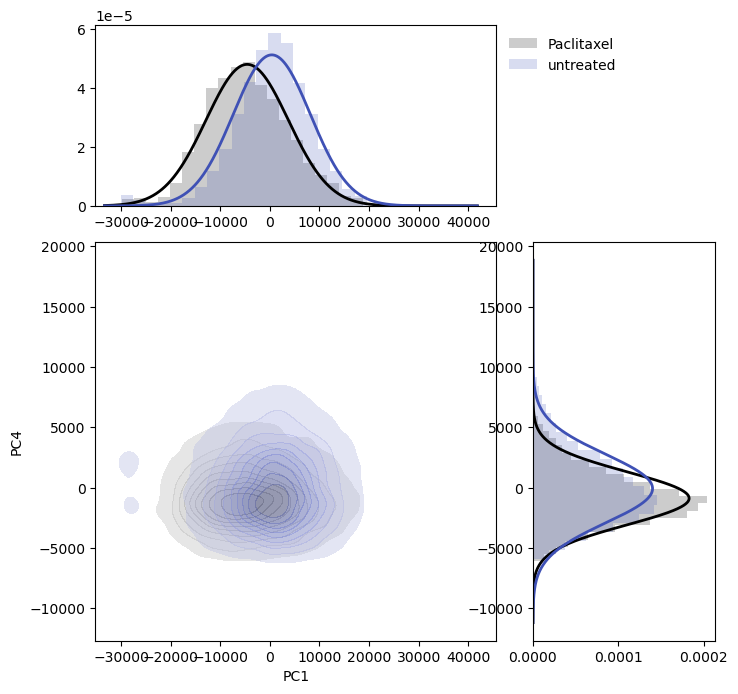

In [18]:
tmp = df_trans[~df_trans.index.str.contains('Vorinostat')]
labels = [f.split('_')[-3] if 'NEGATIVE_CTRL' not in f else 'NEGATIVE_CTRL' for f in tmp.index]
plot_kde_hist(x = tmp["PC1"], y = tmp["PC4"], label=labels, n_bin=20)

0 untreated


1 Vorinostat


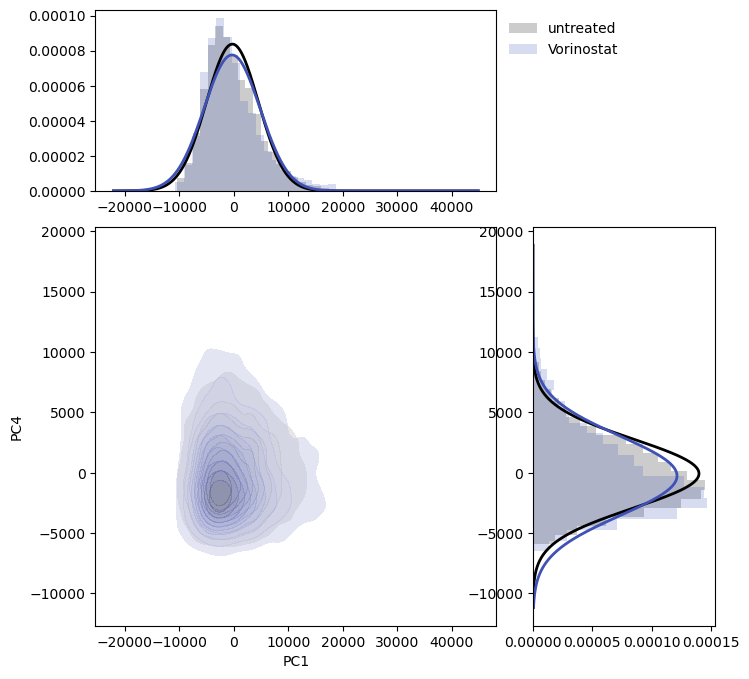

In [19]:
tmp = df_trans[~df_trans.index.str.contains('Paclitaxel')]
labels = [f.split('_')[-3] if 'NEGATIVE_CTRL' not in f else 'NEGATIVE_CTRL' for f in tmp.index]
plot_kde_hist(x = tmp["PC2"], y = tmp["PC4"], label=labels, n_bin=20)

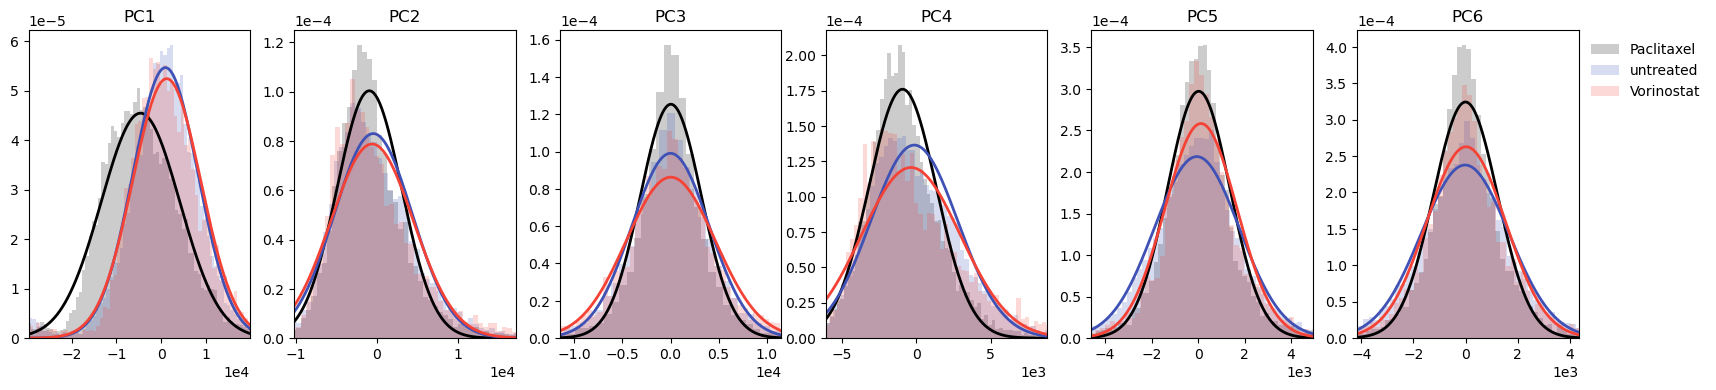

In [20]:
def plot_pcs_hist(df_trans, save_path):
    colors = [
        "#000000",
        "#3f51b5",
        "#f44336",
        "#3226fd",
    ]
    labels = [f.split('_')[-3] if 'NEGATIVE_CTRL' not in f else 'NEGATIVE_CTRL' for f in df_trans.index]
    label = np.asarray(labels)
    fig, axes = plt.subplots(1,6, figsize=(20,4)) #, sharey=True)
    rm_outliers = True
    for PC in range(1,7):
        x = df_trans[f"PC{PC}"]
        for i, i_ in enumerate(set(labels)):
            class_data_x = np.array(x[label == i_])
            axes[PC-1].hist(class_data_x, bins=100, density=True, color=colors[i], alpha=0.2, label=i_)   
            if rm_outliers:
                mu_initial = np.mean(class_data_x)
                std_initial = np.std(class_data_x)
                threshold = 3
                class_data_x = class_data_x[(class_data_x > mu_initial - threshold * std_initial) & (class_data_x < mu_initial + threshold * std_initial)]
            mu, std = norm.fit(class_data_x)
            xmin, xmax = np.min(x), np.max(x) # ax_xDist.get_xlim()
            x_range = np.linspace(xmin, xmax, 10000)
            fitted_line = norm.pdf(x_range, mu, std) #* len(class_data_x)
            axes[PC-1].plot(x_range, fitted_line, color=colors[i], linewidth=2)
            xmin, xmax = np.percentile(x, 1), np.percentile(x, 99)
            axes[PC-1].set_xlim(xmin, xmax)
            axes[PC-1].set_title(f'PC{PC}')
            #axes[PC-1].set_yscale('linear')
            axes[PC-1].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", framealpha=0)
    #plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    plt.savefig(f"{shape_mode_path}/PCs_hist.png")
    
plot_pcs_hist(df_trans, f"{shape_mode_path}/PCs_hist.png")

0 Paclitaxel
1 untreated
2 Vorinostat


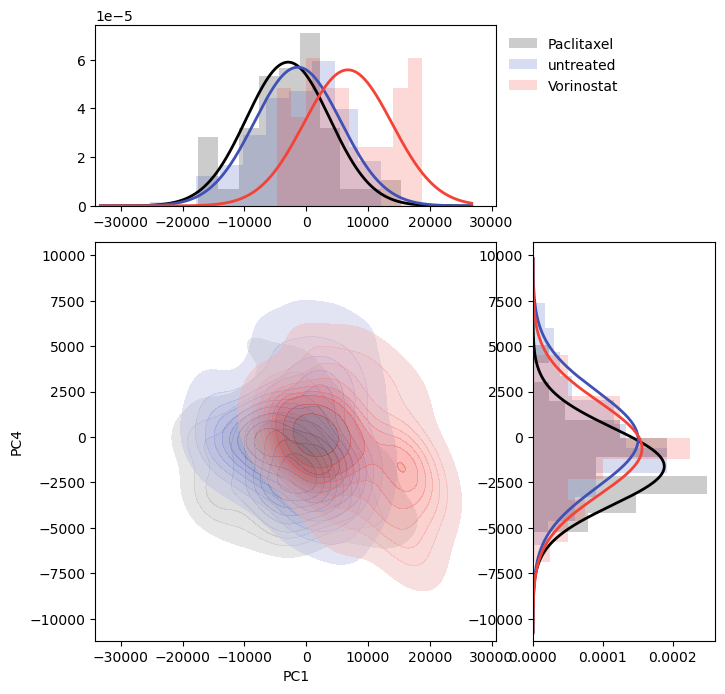

In [21]:
# avg_organelle_dir = '/scratch/users/tle1302/2Dshapespace/B2AI/warps_protein_avg_otsu'
#avg_organelle_dir = '/data/2Dshapespace/B2AI/warps_protein_avg_otsu'
#df = pd.read_csv(f"{avg_organelle_dir}/organelle_distr.csv", header=1)
df = pd.read_csv(f"/data/2Dshapespace/B2AI/lda_on_pilr_accuracy_per_protein.csv")
protein_names = list(set(df.Protein))
protein_name = protein_names[2]
tmp = df_trans[df_trans.index.str.contains(protein_name)]
labels = [f.split('_')[-3] if 'NEGATIVE_CTRL' not in f else 'NEGATIVE_CTRL' for f in tmp.index]
plot_kde_hist(x = tmp["PC1"], y = tmp["PC4"], label=labels, n_bin=10)

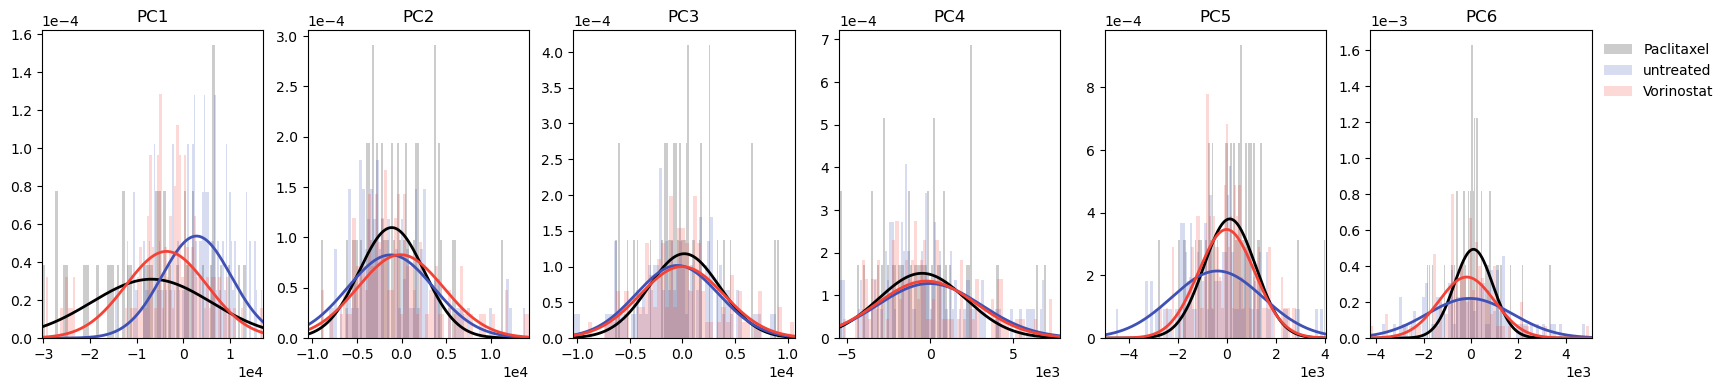

In [22]:
#os.mkdir(f"{shape_mode_path}/PCs_hist_pergene")
protein_names = list(set(df.Protein))
protein_name = protein_names[0] #'NEGATIVE_CTRL'
tmp = df_trans[df_trans.index.str.contains(protein_name)]
plot_pcs_hist(tmp, f"{shape_mode_path}/PCs_hist_pergene/{protein_name}_PCs_hist.png")

In [24]:
import seaborn as sns
import numpy as np
import plotly.graph_objects as go

# generate data
n = 200
x = tmp.PC1
y = tmp.PC2
z = tmp.PC4
groups = [f.split('_')[-3] if 'NEGATIVE_CTRL' not in f else 'NEGATIVE_CTRL' for f in tmp.index]
labels = tmp.index 
# Get unique groups and map them to colors
unique_groups = np.unique(groups)
colors = sns.color_palette("husl", len(unique_groups)).as_hex()
group_colors = [colors[np.where(unique_groups == g)[0][0]] for g in groups]

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=group_colors,   # Set color to the mapped group colors
        opacity=0.5
    ),
    text=[f'{label}, Group: {group}' for label, group in zip(labels, groups)],  # Show labels and group names
    hoverinfo='text'
)])

# Add axis labels
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC4'
    ),
    title=protein_name
)

# Show the plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# Protein heatmap for untreated vs 2 drugs
By segmenting to shape specific, can we see any significance that were masked by populational level?

In [25]:
import json

def flatten_list(list_of_lists):
    """ 
    Function to flatten list of lists, element can be 1 item of a list of items

    Args:
        list_of_lists: list of lists
    Returns: list containing all sub-items
    """
    l = [item for sublist in list_of_lists for item in sublist]
    return l


def get_pc_cell_assignment(cells_assigned, PC="PC1"):
    pc_cells = cells_assigned[PC]
    files = flatten_list(pc_cells)
    bins = [np.repeat(i, len(b)) for i, b in enumerate(pc_cells)]
    bins = flatten_list(bins)
    d = {"image_path": files, PC: bins}
    df = pd.DataFrame.from_dict(d)
    return df

project_dir = '/data/2Dshapespace/B2AI/'
if os.path.exists(f"{project_dir}/single_cell_statistics_pcs.csv"):
    sc_stats = pd.read_csv(f'{project_dir}/single_cell_statistics_pcs.csv')
else:
    sc_stats = pd.read_csv(f'{project_dir}/cell_nu_ratio.txt')
    shape_mode_path = f"{project_dir}/shapemode/fft_cell_major_axis_polarized_cell_nuclei"
    f = open(f"{shape_mode_path}/cells_assigned_to_pc_bins.json", "r")
    cells_assigned = json.load(f)
    print(cells_assigned.keys())
    for PC in cells_assigned.keys():
        df_ = get_pc_cell_assignment(cells_assigned, PC)
        sc_stats = sc_stats.merge(df_, on="image_path")
    sc_stats.to_csv(f"{project_dir}/single_cell_statistics_pcs.csv", index=False)
#tmp = sc_stats.corr(method="pearson")
#tmp.to_csv(f"{cfg.PROJECT_DIR}/single_cell_statistics_corr.csv")
sc_stats = sc_stats[sc_stats.cell_nu_ratio<=8]
sc_stats['treatment'] = 'untreated'
sc_stats.loc[sc_stats.image_path.str.contains('Vorinostat'),'treatment'] = 'Vorinostat'
sc_stats.loc[sc_stats.image_path.str.contains('Paclitaxel'),'treatment'] = 'Paclitaxel'
sc_stats['Protein'] = [f.split('/')[-3] for f in sc_stats.image_path]
sc_stats['Protein_cell_mean'] = sc_stats.Protein_cell_sum/sc_stats.cell_area
sc_stats['Protein_nu_mean'] = sc_stats.Protein_nu_sum/sc_stats.cell_area
sc_stats['Protein_cyt_mean'] = (sc_stats.Protein_cell_sum - sc_stats.Protein_nu_sum)/(sc_stats['cell_area']- sc_stats['nu_area'])



def overlap_percentage(A, B):
    """Calculates the % of pixels in A (nucleus) that overlap with B (cell)."""
    overlap = np.sum(A & B)  # Element-wise AND, counts overlapping 1s
    total_A = np.sum(A)      # Total 1s in A
    return (overlap / total_A) * 100 if total_A > 0 else 0  # Avoid division by zero
res = []
for imgpath in sc_stats.image_path:
    data = np.load(imgpath.replace('/scratch/users/tle1302/2Dshapespace', '/data/2Dshapespace'))
    res.append(overlap_percentage(data[1,:,:], data[0,:,:]))
sc_stats['nucleus_inside_cell'] = res
sc_stats = sc_stats[(sc_stats.cell_nu_ratio < 8) & (sc_stats.cell_nu_ratio > 1) & (sc_stats.nucleus_inside_cell > 90)]


# Filter out negative expression based on NEGATIVE_CTRL
thres = np.percentile(sc_stats[sc_stats.Protein.str.contains('NEGATIVE_CTRL')].Protein_cell_mean, 99)
sc_stats = sc_stats[sc_stats.Protein_cell_mean > thres]
sc_stats = sc_stats[sc_stats.Protein_cyt_mean > 0]

In [26]:
sc_stats.shape

(29174, 21)

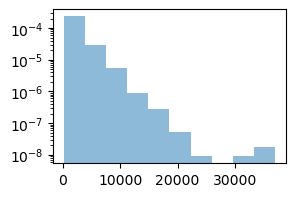

In [ ]:
# plt.hist(sc_stats[sc_stats.Protein.str.contains('NEGATIVE_CTRL')].Protein_cell_mean, density=True)
plt.figure(figsize=(3,2))
plt.hist(sc_stats[sc_stats.Protein !='NEGATIVE_CTRL'].Protein_cell_mean, density=True, alpha=0.5)
plt.yscale('log')

In [ ]:
if False:
    # Intensity hits: 'HPA026588_DNMT3A', 'HPA028926_HDAC9', 'HPA077805_PRKAG1'
    # Spatial hits: 'HPA023567_MSL1', 'HPA072136_PRMT1'
    protein = "HPA048431_KMT3B"#"HPA022133_53BP1" #'CAB080430_DNMT1'#'HPA065704_RAG2'#'HPA044342_PRKAB2' #'HPA011165_SIRT2'# #'HPA051773_BRE1A'#
    avg_organelle_dir = '/data/2Dshapespace/B2AI/warps'
    pc = "PC1"
    fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,10))
    for j, b in enumerate([0,3,4]):
        for i, treatment in enumerate(['untreated','Vorinostat','Paclitaxel']):
            ax[i, j].imshow(plt.imread(f"{avg_organelle_dir}/{pc}_{protein}_{treatment}_b{b}.png"), origin='lower')
            ax[i, j].set_title(f'{treatment}, b{j}')
    plt.suptitle(protein)
    df[(df.PC == pc) & (df.Protein == protein)]

In [ ]:
# boxplot_style2_group(sc_stats, protein, value = "Protein_cyt_mean", PC=pc)

In [27]:
#sc_stats[sc_stats.Protein == protein].groupby(['treatment','PC1'])

sc_stats[(sc_stats.Protein == protein) & 
         (sc_stats.treatment == 'Vorinostat') & 
         (sc_stats.PC1.isin([0,1]))].image_path.values

NameError: name 'protein' is not defined

In [ ]:
#import cv2
#image_np = plt.imread('/data/2Dshapespace/B2AI/MDA-MB-468/Tiffs/B2AI-2023-1/HPA023567_MSL1/B2AI_1_Vorinostat_A2_R1/z01/C3.tif')
#_, image_np = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#plt.imshow(image_np)

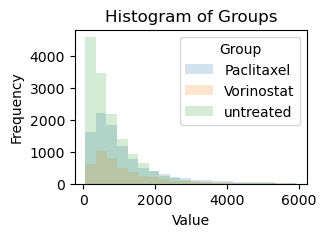

In [29]:
value = 'Protein_nu_mean'
xmin, xmax = np.percentile(sc_stats[value], 1), np.percentile(sc_stats[value], 99)

df_ = sc_stats[(sc_stats[value] > xmin) & (sc_stats[value] < xmax)]
groups = df_.groupby('treatment')


fig, ax = plt.subplots(figsize=(3,2))
for group_name, group_data in groups:
    group_data[value].hist(ax=ax, alpha=0.2, label=group_name, bins=20)

# Add legend, labels, and title
ax.legend(title='Group')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Groups')
ax.grid(False)

In [30]:
import seaborn as sns
from scipy.stats import ttest_ind, kruskal, false_discovery_control, mannwhitneyu
def boxplots_style2(sub_df, antibody, value = "Protein_nu_mean", ax=None):
    
    sub_df.loc[:, 'log1p_Protein_value'] = np.log10(sub_df.loc[:,value])
    #sub_df.loc[:, 'log1p_Protein_value'] = np.log2(sub_df.loc[:,value])
    #sub_df.loc[:, 'log1p_Protein_value'] = np.log1p(sub_df.loc[:,value]) # np.log10(sub_df.loc[:,value] + 0.000001)
    groups = {i:sub_df[sub_df['groups'] == i][value] for i in ['untreated','Vorinostat','Paclitaxel']}
    kw_result = kruskal(groups['untreated'], groups['Vorinostat'], groups['Paclitaxel'])

    ax.set_title(f'Kruskal-Wallis Test: H = {kw_result.statistic:.2f}, p = {kw_result.pvalue:.2e}')

    sns.boxplot(x ='groups', y='log1p_Protein_value', data=sub_df, fill=False, ax=ax, color = "skyblue", showfliers = False)
    sns.violinplot(x ='groups', y='log1p_Protein_value', data=sub_df, ax=ax, color = "skyblue", alpha=0.5)
    #sns.swarmplot(x ='groups', y='log1p_Protein_value', data=sub_df, color=".25", ax=ax, alpha=0.5)
    x1, x2, x3 = 0, 1, 2   # (first column: 0, see plt.xticks())

    #_, pval02 = ttest_ind(groups[0], groups[2], equal_var=False)
    #_, pval01 = ttest_ind(groups[0], groups[1], equal_var=False)
    try:
        _, pval02 = mannwhitneyu(groups['untreated'], groups['Paclitaxel'])
        _, pval01 = mannwhitneyu(groups['untreated'], groups['Vorinostat'])
        try: #FDR if avail
            padjs = false_discovery_control([pval02, pval01], method='BH')
        except:
            padjs = [pval02, pval01]
    except:
        padjs = [1, 1]
    #print(pval02, pval01, padjs)
    y, h, col = sub_df.log1p_Protein_value.max()*1.06, 0.01, 'k'
    ax.plot([x1, x1, x3, x3], [y, y+h, y+h, y], lw=1.5, c=col)
    if padjs[0] < 0.05:
        ax.text((x1+x3)*.5, y+h, f"padj={padjs[0]:.1E}", ha='center', va='bottom', color=col)
    else:
        ax.text((x1+x3)*.5, y+h, "NA", ha='center', va='bottom', color=col)
    y, h, col = sub_df.log1p_Protein_value.max()*1.02, 0.01, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    if padjs[1] < 0.05:
        ax.text((x1+x2)*.5, y+h, f"padj={padjs[1]:.1E}", ha='center', va='bottom', color=col)
    else:
        ax.text((x1+x2)*.5, y+h, "NA", ha='center', va='bottom', color=col)
        
    ax.set_ylabel(f"log10({value})")
    ax.set_xticks([0,1,2], [f"untreated \n n={len(groups['untreated'])}", 
                            f"Vorinostat \n n={len(groups['Vorinostat'])}", 
                            f"Paclitaxel \n n={len(groups['Paclitaxel'])}"])
    
def boxplot_style2_group(sc_stats, protein, value = "Protein_nu_mean", PC='PC1'):
    tmp = sc_stats[sc_stats.Protein==protein]

    xmin, xmax = np.percentile(tmp[value], 1), np.percentile(tmp[value], 99)
    tmp = tmp[(tmp[value] > xmin) & (tmp[value] < xmax)]
    
    fig, axes = plt.subplots(1,4, figsize=(20,5), sharey=True)
    boxplots_style2(tmp, None, value = value, ax = axes[0])
    axes[0].set_xlabel('all cells')
    boxplots_style2(tmp[tmp[PC].isin([0,1,2])], None, value = value, ax = axes[1])
    axes[1].set_xlabel(f'{PC} - left')
    boxplots_style2(tmp[tmp[PC].isin([3])], None, value = value, ax = axes[2])
    axes[2].set_xlabel(f'{PC} - center')
    boxplots_style2(tmp[tmp[PC].isin([4,5,6])], None, value = value, ax = axes[3])
    axes[3].set_xlabel(f'{PC} - right')
    plt.suptitle(f'{protein} {value}')
    plt.savefig(f'{project_dir}/plots/{protein}_{PC}_violinplots.png')

In [31]:
sc_stats[sc_stats.Protein=='HPA046793_NEDD4'].groupby('treatment').agg({'Protein_nu_mean':'mean',
                                'Protein_cell_mean':'mean',
                                'Protein_cyt_mean':'mean'})

,Protein_nu_mean,Protein_cell_mean,Protein_cyt_mean
treatment,,,
Paclitaxel,829.551046,1537.582757,1219.455182
Vorinostat,1107.134618,1888.668519,1407.765152
untreated,721.695556,1425.677978,1139.712114


/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future ver

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future ver

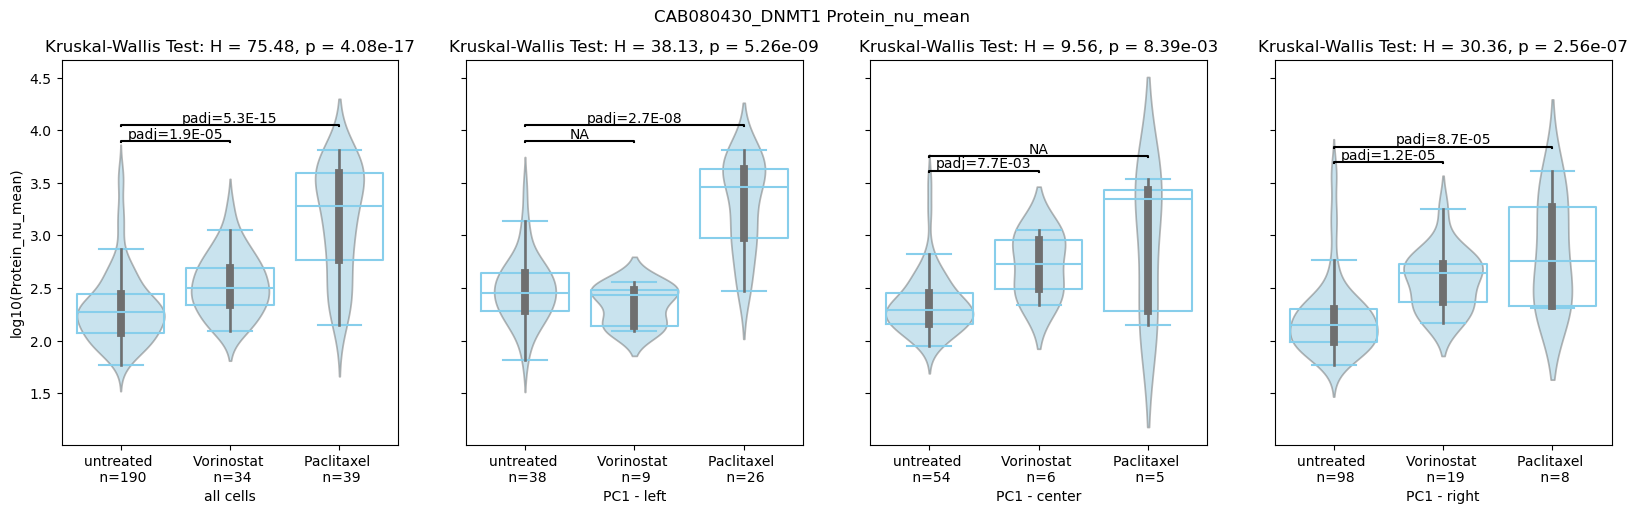

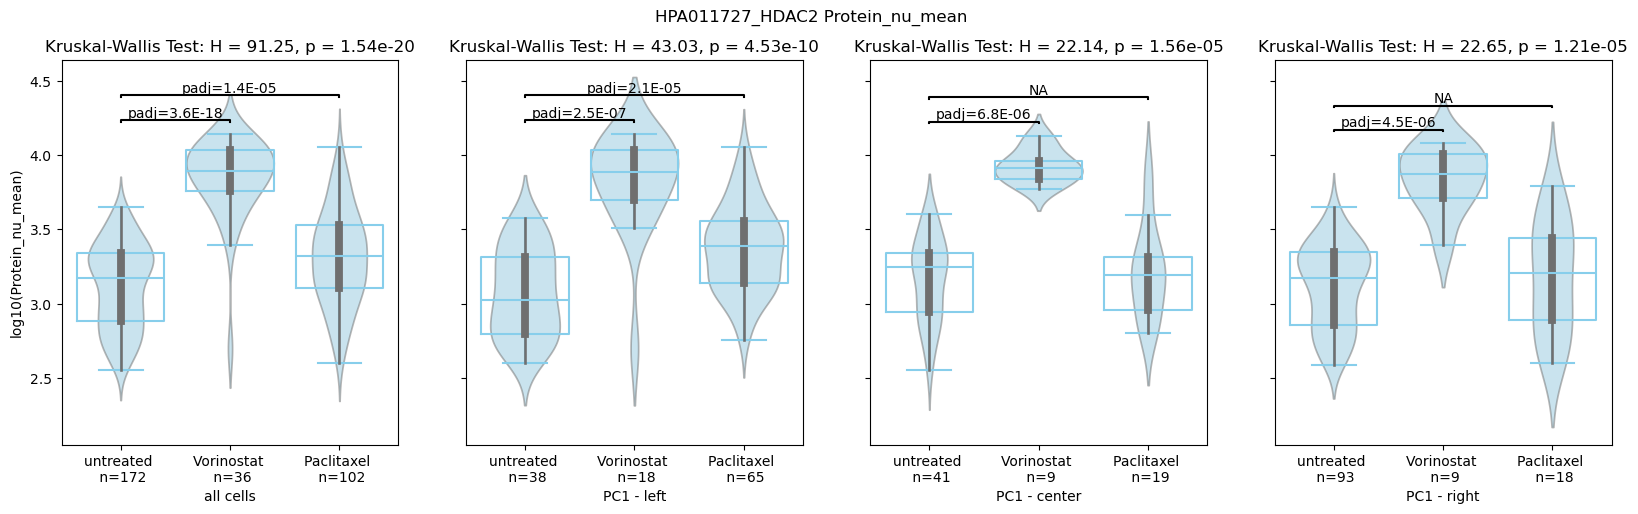

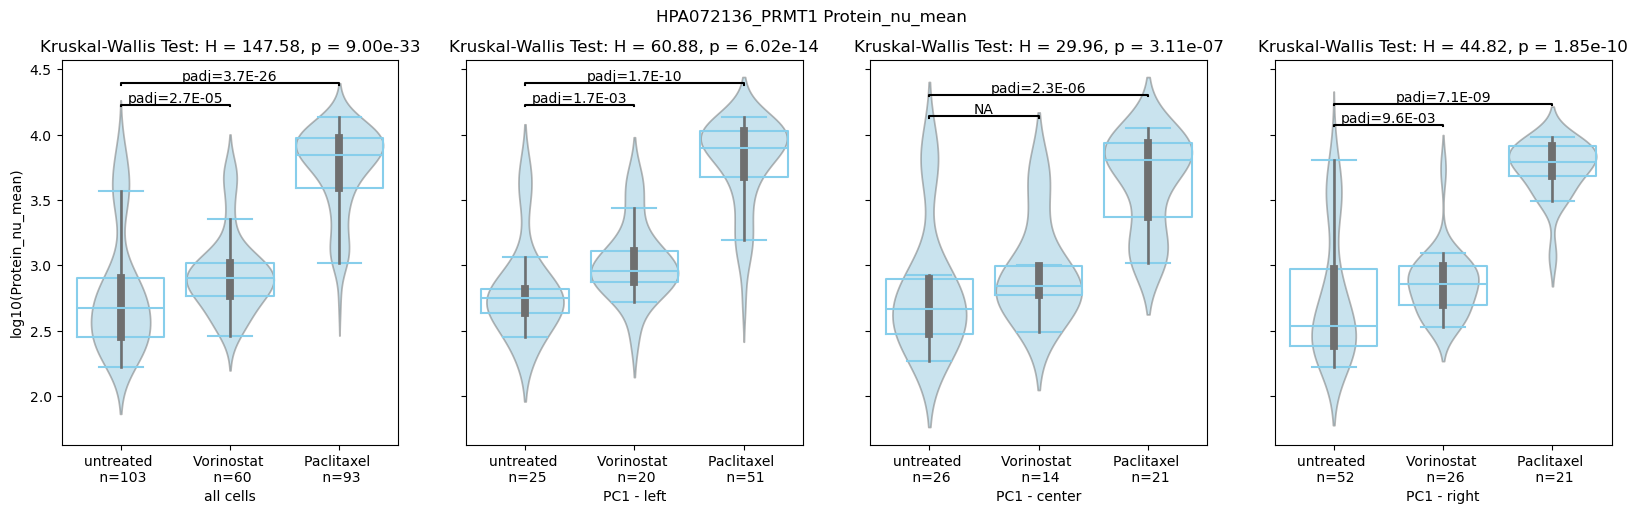

In [32]:
sc_stats['groups'] = pd.Categorical(sc_stats.treatment, ordered=True, categories=['untreated','Vorinostat', 'Paclitaxel'])

proteins = set(sc_stats.Protein)
proteins = ['CAB080430_DNMT1', 'HPA011727_HDAC2', 'HPA072136_PRMT1',
       'HPA051773_BRE1A', 'HPA026588_DNMT3A', 'HPA022133_53BP1',
       'HPA001023_PHF6', 'HPA048431_KMT3B', 'HPA028926_HDAC9',
       'HPA055861_KAT3A', 'HPA023567_MSL1', 'HPA048340_BRG1',
       'HPA016610_KDM3B', 'HPA065704_RAG2', 'CAB080426_HDAC8',
       'HPA029069_BPTF', 'HPA061646_BRD4']
for protein in proteins[:3]:
    boxplot_style2_group(sc_stats, protein, value = "Protein_nu_mean", PC='PC1')

In [ ]:
#sc_stats[sc_stats.Protein.str.contains("BRE1A")]

### Potentially interesting hits:
HPA011165_SIRT2
CAB080430_DNMT1
HPA061717_TRIM24
HPA022236_CHD1
HPA016610_KDM3B
HPA051773_BRE1A

In [ ]:
#for protein, sub_df in sc_stats.groupby('Protein'):
tmp
#tmp[['treatment','PC1']].value_counts()

,Protein,Treatment_Comparison,Fold_Change_round,log2_Fold_Change_round,P_Value_round,Significance_round,Fold_Change_all,log2_Fold_Change_all,P_Value_all,Significance_all,FC_diff
0,53BP1,Paclitaxel vs untreated,0.355443,-1.492312,1.440973e-14,Downregulated,0.381142,-1.391600,2.686371e-44,Downregulated,0.025699
1,53BP1,Vorinostat vs untreated,1.584818,0.664317,9.282159e-06,Not Significant,1.793918,0.843114,5.032238e-26,Not Significant,0.209100
2,ARTD1,Paclitaxel vs untreated,1.191893,0.253254,1.352469e-01,Not Significant,1.403150,0.488669,7.970231e-06,Not Significant,0.211257
3,ARTD1,Vorinostat vs untreated,1.958348,0.969637,3.657991e-16,Not Significant,2.061696,1.043832,9.325880e-30,Upregulated,0.103348
4,ATM,Paclitaxel vs untreated,0.651019,-0.619229,1.077107e-06,Not Significant,0.733820,-0.446501,1.270498e-17,Not Significant,0.082801
...,...,...,...,...,...,...,...,...,...,...,...
187,YWHAE,Vorinostat vs untreated,1.082305,0.114107,4.078950e-01,Not Significant,1.063290,0.088536,2.923026e-01,Not Significant,0.019014
188,YWHAG,Paclitaxel vs untreated,0.702112,-0.510226,2.385581e-09,Not Significant,0.783288,-0.352385,1.069404e-15,Not Significant,0.081176
189,YWHAG,Vorinostat vs untreated,0.873555,-0.195030,2.019916e-02,Not Significant,0.848253,-0.237433,5.843187e-03,Not Significant,0.025301
190,YWHAZ,Paclitaxel vs untreated,2.167507,1.116036,1.361435e-06,Upregulated,2.647508,1.404635,2.420946e-15,Upregulated,0.480001


In [33]:

def t_tests_on_groups(df, value='Protein_nu_mean'):
    results = []
    for name, group in df.groupby('antibody'):
        feature_names = get_regions_to_consider(str(group.locations.unique()[0]).split(','))
        for value in feature_names:
            groups = [group[group['groups'] == i][value] for i in [0,1,2]]
            t12, p12 = ttest_ind(groups[0], groups[1], equal_var=False)
            t23, p23 = ttest_ind(groups[1], groups[2], equal_var=False)
            t13, p13 = ttest_ind(groups[0], groups[2], equal_var=False)
            n1, n2, n3 = len(groups[0]), len(groups[1]), len(groups[2])
            results.append({
                'antibody': name,
                'gene_names': group.gene_names.unique()[0],
                'location': group.locations.unique()[0],
                'region': value,
                'g1_means': groups[0].mean(), 'g2_means': groups[1].mean(), 'g3_means': groups[2].mean(),
                't_1vs2': t12, 'p_1vs2': p12,
                't_2vs3': t23, 'p_2vs3': p23, 
                't_1vs3': t13, 'p_1vs3': p13,
                'n_group1': n1, 'n_group2': n2, 'n_group3': n3,
            })     
    return pd.DataFrame(results)

In [ ]:
import numpy as np
#avg_cell = np.load('/scratch/users/tle1302/2Dshapespace/B2AI/shapemode/fft_cell_major_axis_polarized_cell_nuclei/Avg_cell.npz')
#avg_cell = np.load('/scratch/users/tle1302/2Dshapespace/B2AI/shapemode/fft_cell_major_axis_polarized_cell_nuclei_test/Avg_cell.npz')
import matplotlib.pyplot as plt
#plt.imshow(plt.imread('/data/2Dshapespace/B2AI/shapemode/fft_cell_major_axis_polarized_cell_nuclei/Avg_cell.jpg'))

In [34]:
import pandas as pd
import numpy as np
from scipy import stats
#from statsmodels.stats.multitest import multipletests

# Generate sample data
# Assuming df is the DataFrame containing your data
# Sample columns: Protein, value1, group, treatment

# Function to calculate log2 fold change
def log2_fold_change(group1, group2):
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    fc = mean2 / mean1
    return fc, np.log2(fc)

# Function to perform statistical comparison (t-test)
def compare_groups(df, treatment1, treatment2, value):
    group1 = df[df['treatment'] == treatment1][value]
    group2 = df[df['treatment'] == treatment2][value]
    fc, log2fc = log2_fold_change(group1, group2)
    t_stat, p_val = stats.ttest_ind(group1, group2)
    return fc, log2fc, p_val, len(group1), len(group2)

# Subset by group and calculate fold changes
def compare_by_group(df, group_col, treatment1, treatment2, value):
    results = []
    # foldchange for all data
    fc, log2fc, p_val, n1, n2 = compare_groups(df, treatment1, treatment2, value)
    results.append({
        'Group': 'all',
        'Treatment_Comparison': f'{treatment2} vs {treatment1}',
        'Fold_Change': fc,
        'log2_Fold_Change': log2fc,
        'P_Value': p_val,
        'n_treatmant1': n1,
        'n_treatment2': n2
    })
        
    groups = df[group_col].unique()
    for grp in groups:
        df_grp = df[df[group_col] == grp]
        fc, log2fc, p_val, n1, n2 = compare_groups(df_grp, treatment1, treatment2, value)
        results.append({
            'Group': grp,
            'Treatment_Comparison': f'{treatment2} vs {treatment1}',
            'Fold_Change': fc,
            'log2_Fold_Change': log2fc,
            'P_Value': p_val,
            'n_treatmant1': n1,
            'n_treatment2': n2
        })
    return pd.DataFrame(results)

# Main comparison: treatment1 vs untreated, treatment2 vs untreated
def compare_treatments(df, group_col, value='Protein_nu_mean'):
    untreated_vs_treat1 = compare_by_group(df, group_col, 'untreated', 'Paclitaxel', value)
    untreated_vs_treat2 = compare_by_group(df, group_col, 'untreated', 'Vorinostat', value)
    
    # Combine results
    results = pd.concat([untreated_vs_treat1, untreated_vs_treat2])
    
    return results

protein = 'HPA046793_NEDD4'
value = 'Protein_cell_mean'
# Display the result
res = compare_treatments(sc_stats[sc_stats.Protein==protein], group_col='PC1',value=value)
res["Protein"] = protein
res["value"] = value
res.sort_values('Fold_Change')
# Correct for multiple comparisons using FDR (Benjamini-Hochberg method)
#results['FDR_Adjusted_P'] = '0'#multipletests(results['P_Value'], method='fdr_bh')[1]

,Group,Treatment_Comparison,Fold_Change,log2_Fold_Change,P_Value,n_treatmant1,n_treatment2,Protein,value
7,5,Vorinostat vs untreated,0.712370,-0.489301,4.886732e-02,16,2,HPA046793_NEDD4,Protein_cell_mean
4,2,Paclitaxel vs untreated,0.917731,-0.123857,3.813416e-01,12,41,HPA046793_NEDD4,Protein_cell_mean
3,0,Vorinostat vs untreated,0.984626,-0.022352,8.293527e-01,2,3,HPA046793_NEDD4,Protein_cell_mean
5,3,Paclitaxel vs untreated,1.013723,0.019664,8.690513e-01,17,25,HPA046793_NEDD4,Protein_cell_mean
6,4,Paclitaxel vs untreated,1.033623,0.047709,7.636159e-01,25,13,HPA046793_NEDD4,Protein_cell_mean
1,6,Paclitaxel vs untreated,1.048342,0.068109,7.334066e-01,13,6,HPA046793_NEDD4,Protein_cell_mean
3,0,Paclitaxel vs untreated,1.064014,0.089518,8.430788e-01,2,29,HPA046793_NEDD4,Protein_cell_mean
7,5,Paclitaxel vs untreated,1.074582,0.103776,5.469555e-01,16,5,HPA046793_NEDD4,Protein_cell_mean
0,all,Paclitaxel vs untreated,1.078492,0.109016,8.204366e-02,93,145,HPA046793_NEDD4,Protein_cell_mean
2,1,Paclitaxel vs untreated,1.162555,0.217299,2.220122e-01,8,26,HPA046793_NEDD4,Protein_cell_mean


/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/scipy/stats/_stats_py.py:6951: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_479830/3606240232.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



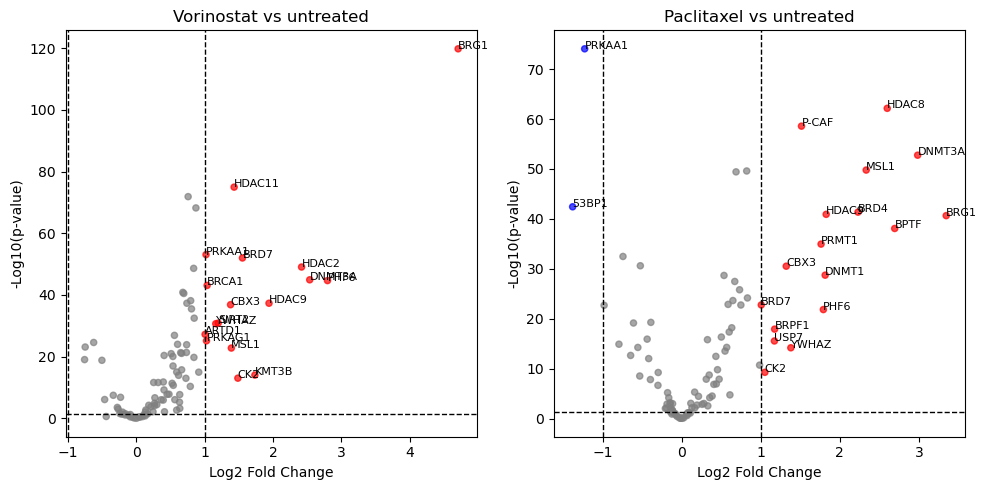

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_volcano_plots(data, save_path='volcano_plot.png'):
    fold_change_threshold = 1.0
    p_value_threshold = 0.05

    # Define categories for coloring points based on significance
    data['Significance'] = 'Not Significant'
    data.loc[(data['log2_Fold_Change'] > fold_change_threshold) & (data['P_Value'] < p_value_threshold), 'Significance'] = 'Upregulated'
    data.loc[(data['log2_Fold_Change'] < -fold_change_threshold) & (data['P_Value'] < p_value_threshold), 'Significance'] = 'Downregulated'

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Function to add a volcano plot for each condition
    def add_volcano_plot(ax, data, condition):
        filtered_data = data[data['Treatment_Comparison'] == condition]
        
        # Plot data points with colors based on significance
        colors = filtered_data['Significance'].map({
            'Not Significant': 'grey',
            'Upregulated': 'red',
            'Downregulated': 'blue'
        })
        ax.scatter(filtered_data['log2_Fold_Change'], -np.log10(filtered_data['P_Value']), c=colors, alpha=0.7, s=20)

        # Label the upregulated and downregulated points
        for i, row in filtered_data.iterrows():
            if row['Significance'] in ['Upregulated', 'Downregulated']:
                ax.text(row['log2_Fold_Change'], -np.log10(row['P_Value']), row['Protein'], fontsize=8)

        # Add threshold lines
        ax.axhline(y=-np.log10(p_value_threshold), color='black', linestyle='--', lw=1)
        ax.axvline(x=fold_change_threshold, color='black', linestyle='--', lw=1)
        ax.axvline(x=-fold_change_threshold, color='black', linestyle='--', lw=1)

        ax.set_title(condition)
        ax.set_xlabel('Log2 Fold Change')
        ax.set_ylabel('-Log10(p-value)')

    # Add volcano plot for Condition A in the first subplot
    add_volcano_plot(axs[0], data, 'Vorinostat vs untreated')

    # Add volcano plot for Condition B in the second subplot
    add_volcano_plot(axs[1], data, 'Paclitaxel vs untreated')

    # Adjust layout and save as PNG
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

result_table = []
sc_stats['Protein_name'] = [f.split('_')[1] for f in sc_stats.Protein]
value = 'Protein_cell_mean'
for protein in sc_stats.Protein_name.unique():
    res = compare_treatments(sc_stats[sc_stats.Protein_name==protein], group_col='PC4', value=value)
    res["Protein"] = protein
    res["value"] = value
    result_table.append(res)
result_table = pd.concat(result_table)
plot_volcano_plots(result_table[result_table.Group=='all'], save_path='volcano_plot_PC4_all.png')
result_table = result_table[(result_table.Group=='all') & (~result_table.P_Value.isna())]
result_table['FDR'] = stats.false_discovery_control(result_table['P_Value'], method='BH')[1]
result_table['Significance'] = 'Not Significant'
result_table['Significance'] = 'Not Significant'
result_table.loc[(result_table['log2_Fold_Change'] > 1) & (result_table['P_Value'] < 0.01), 'Significance'] = 'Upregulated'
result_table.loc[(result_table['log2_Fold_Change'] < -1) & (result_table['P_Value'] < 0.01), 'Significance'] = 'Downregulated'

#all_sig = result_table[(result_table.Group == 'all') & (result_table.Significance != 'Not Significant')].sort_values('Fold_Change')
all_sig = result_table[(result_table.Group == 'all')][['Protein','Treatment_Comparison','Fold_Change','log2_Fold_Change','P_Value','Significance']]

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/scipy/stats/_stats_py.py:6951: RuntimeWarning:

invalid value encountered in scalar divide

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/scipy/stats/_stats_py.py:6951: RuntimeWarning:

invalid value encountered in scalar divide

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/scipy/stats/_stats_py.py:6951: RuntimeWarning:

invalid value encountered in scalar divide

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/scipy/stats/_stats_py.py:6951: RuntimeWarning:

invalid value encountered in scalar divide

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/scipy/stats/_stats_py.py:6951: RuntimeWarning:

invalid value encountered in scalar divide

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/scipy/stats/_stats_py.py:6951: RuntimeWarning:

invalid value encountered in scalar divide

/home/trangle/miniconda3/env

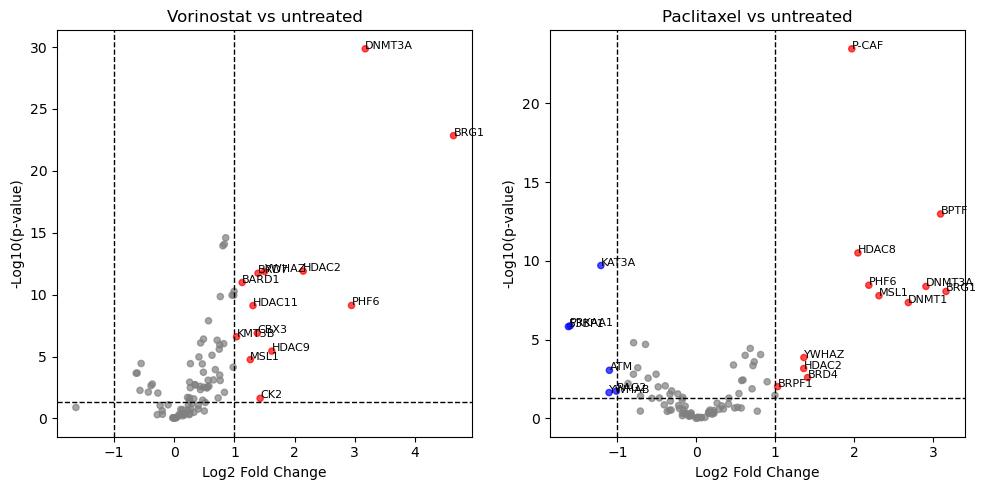

In [36]:
result_table = []
#sc_stats['Protein_name'] = [f.split('_')[1] for f in sc_stats.Protein]
# value = 'Protein_cell_mean'
for protein in sc_stats.Protein_name.unique():
    #res = compare_treatments(sc_stats[(sc_stats.Protein_name==protein) & sc_stats.PC4.isin([0,1,2]) & sc_stats.PC1.isin([4,5,6])], group_col='PC4', value=value)
    #res = compare_treatments(sc_stats[(sc_stats.Protein_name==protein) & sc_stats.PC4.isin([4,5,6]) & sc_stats.PC1.isin([0,1,2])], group_col='PC1', value=value)
    res = compare_treatments(sc_stats[(sc_stats.Protein_name==protein) & sc_stats.PC4.isin([4,5,6]) & sc_stats.PC1.isin([4,5,6])], group_col='PC1', value=value)

    res["Protein"] = protein
    res["value"] = value
    result_table.append(res)
result_table = pd.concat(result_table)
plot_volcano_plots(result_table[result_table.Group=='all'], save_path='volcano_plot_PC4_largecell.png')
result_table = result_table[(result_table.Group=='all') & (~result_table.P_Value.isna())]
result_table['FDR'] = stats.false_discovery_control(result_table['P_Value'], method='BH')[1]
result_table['Significance'] = 'Not Significant'
result_table.loc[(result_table['log2_Fold_Change'] > 1) & (result_table['FDR'] < 0.01), 'Significance'] = 'Upregulated'
result_table.loc[(result_table['log2_Fold_Change'] < -1) & (result_table['FDR'] < 0.01), 'Significance'] = 'Downregulated'

#round_sig = result_table[(result_table.Group == 'all') & (result_table.Significance != 'Not Significant')].sort_values('Fold_Change')
round_sig = result_table[(result_table.Group == 'all')][['Protein','Treatment_Comparison','Fold_Change','log2_Fold_Change','P_Value','FDR','Significance']]

In [ ]:
result_table.sort_values('P_Value')

,Group,Treatment_Comparison,Fold_Change,log2_Fold_Change,P_Value,n_treatmant1,n_treatment2,Protein,value
0,all,Vorinostat vs untreated,9.049689,3.177868,1.381993e-30,31,15,DNMT3A,Protein_cell_mean
0,all,Paclitaxel vs untreated,3.915711,1.969274,3.395415e-24,35,6,P-CAF,Protein_cell_mean
0,all,Vorinostat vs untreated,25.040743,4.646205,1.421159e-23,16,6,BRG1,Protein_cell_mean
0,all,Vorinostat vs untreated,1.809303,0.855434,2.556343e-15,60,11,CBL,Protein_cell_mean
0,all,Vorinostat vs untreated,1.780916,0.832620,8.343430e-15,35,8,P-CAF,Protein_cell_mean
...,...,...,...,...,...,...,...,...,...
0,all,Paclitaxel vs untreated,NaN,NaN,NaN,0,2,PPP4C,Protein_cell_mean
0,all,Vorinostat vs untreated,NaN,NaN,NaN,0,8,PPP4C,Protein_cell_mean
0,all,Paclitaxel vs untreated,NaN,NaN,NaN,0,0,CTRL,Protein_cell_mean
0,all,Vorinostat vs untreated,NaN,NaN,NaN,0,0,CTRL,Protein_cell_mean


In [ ]:
# Check the largest change
tmp = round_sig.merge(all_sig, on=['Protein','Treatment_Comparison'], how='outer', suffixes=('_round', '_all'))
tmp['FC_diff'] = abs(tmp['Fold_Change_round'] - tmp['Fold_Change_all'])
#tmp.sort_values('Significance_all')#, ascending=False).head(3)

In [ ]:
#round_sig[round_sig.Protein.isin(set(round_sig.Protein).difference(all_sig.Protein))]
#set(all_sig.Protein).difference(round_sig.Protein)
#tmp[tmp.Treatment_Comparison == 'Vorinostat vs untreated'].sort_values('FC_diff', ascending=False).head(3)

if False: #for protein, df_ in tmp[tmp.Treatment_Comparison == 'Paclitaxel vs untreated'].groupby('Protein'):
    #print(df_)
    x = df_.log2_Fold_Change_round
    y = df_.log2_Fold_Change_all
    #print(x, y)
    c = df_.Significance_round.map({'Not Significant': 'grey', 'Upregulated': 'red', 'Downregulated': 'blue'})
    plt.scatter(x, y, marker='0', color=c)
    #if c[0] != 'grey':
    #    plt.text(x+.03, y+.03, protein, fontsize=9)
    plt.text(x+.03, y+.03, protein, fontsize=9)
#plt.scatter(tmp[tmp.Treatment_Comparison == 'Paclitaxel vs untreated'].log2_Fold_Change_round, 
#         tmp[tmp.Treatment_Comparison == 'Paclitaxel vs untreated'].log2_Fold_Change_all, 'o', c='gray')
#plt.plot(range(5), range(5), )

ATM
BRE1A
HDAC2
KAT3A
PPP4C
PRKCD
RAG2
YWHAB


/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/text.py:1461: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/text.py:1463: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/text.py:753: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/text.py:754: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/home/trangle/miniconda3/envs/shapespace/l

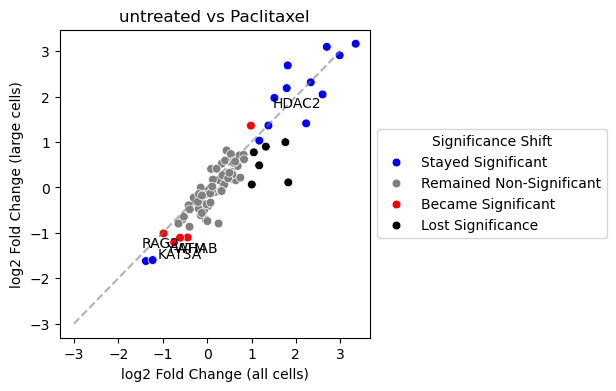

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define significance threshold
pval_threshold = 0.05

# Determine significance categories
def get_status(row):
    if row.Significance_round != 'Not Significant' and row.Significance_all == 'Not Significant':
    #row['P_Value_all'] >= pval_threshold and row['P_Value_round'] < pval_threshold:
        return "Became Significant"
    #elif row['P_Value_all'] < pval_threshold and row['P_Value_round'] < pval_threshold:
    elif row.Significance_round != 'Not Significant' and row.Significance_all != 'Not Significant':
        return "Stayed Significant"
    #elif row['P_Value_all'] < pval_threshold and row['P_Value_round'] >= pval_threshold:
    elif row.Significance_round == 'Not Significant' and row.Significance_all != 'Not Significant':
        return "Lost Significance"
    else:
        return "Remained Non-Significant"


tmp = round_sig.merge(all_sig, on=['Protein','Treatment_Comparison'], how='outer', suffixes=('_round', '_all'))
tmp['Status'] = tmp.apply(get_status, axis=1)
df = tmp[tmp.Treatment_Comparison == 'Paclitaxel vs untreated']
# Set color palette
palette = {
    "Became Significant": "red",
    "Stayed Significant": "blue",
    "Lost Significance": "black",
    "Remained Non-Significant": "gray"
}

# Scatter plot of log2FC_ori vs log2FC_2
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x=df["log2_Fold_Change_all"], 
    y=df["log2_Fold_Change_round"], 
    hue=df["Status"], 
    palette=palette, 
    #edgecolor="black", 
    s=40
)
for p in df[df.Status == 'Became Significant'].Protein.unique():
    print(p)
    plt.annotate(p, (df[df.Protein == p].log2_Fold_Change_all *1.5, df[df.Protein == p].log2_Fold_Change_round * 1.3))

# Add diagonal reference line (y = x)
plt.plot([-3, 3], [-3, 3], linestyle="--", color="gray", alpha=0.6)

# Labels and title
plt.xlabel("log2 Fold Change (all cells)")
plt.ylabel("log2 Fold Change (large cells)")
plt.title("untreated vs Paclitaxel")#"Shift in Protein Significance Between Conditions")
plt.legend(title="Significance Shift", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [ ]:
df[df.Status == 'Became Significant']

,Protein,Treatment_Comparison,Fold_Change_round,log2_Fold_Change_round,P_Value_round,FDR,Significance_round,Fold_Change_all,log2_Fold_Change_all,P_Value_all,Significance_all,Status
4,ATM,Paclitaxel vs untreated,0.466186,-1.101024,8.755366e-04,0.008403,Downregulated,0.738924,-0.436502,1.247060e-16,Not Significant,Became Significant
26,BRE1A,Paclitaxel vs untreated,NaN,NaN,NaN,NaN,NaN,0.692426,-0.530268,3.050323e-09,Not Significant,Became Significant
60,HDAC2,Paclitaxel vs untreated,2.567176,1.360182,6.741754e-04,0.008403,Upregulated,1.980194,0.985642,2.002594e-11,Not Significant,Became Significant
84,KAT3A,Paclitaxel vs untreated,0.432569,-1.208997,1.953653e-10,0.008403,Downregulated,0.597838,-0.742173,3.416253e-33,Not Significant,Became Significant
138,PPP4C,Paclitaxel vs untreated,NaN,NaN,NaN,NaN,NaN,0.577035,-0.793269,1.285843e-15,Not Significant,Became Significant
158,PRKCD,Paclitaxel vs untreated,NaN,NaN,NaN,NaN,NaN,0.906783,-0.141171,4.763946e-02,Not Significant,Became Significant
162,RAG2,Paclitaxel vs untreated,0.495821,-1.012108,1.835508e-02,0.008403,Downregulated,0.506626,-0.981008,2.068949e-23,Not Significant,Became Significant
182,YWHAB,Paclitaxel vs untreated,0.464657,-1.105761,2.270976e-02,0.008403,Downregulated,0.655506,-0.609319,7.319911e-20,Not Significant,Became Significant


(array([1, 2, 3]),
 [Text(1, 0, 'Paclitaxel'), Text(2, 0, 'Vorinostat'), Text(3, 0, 'untreated')])

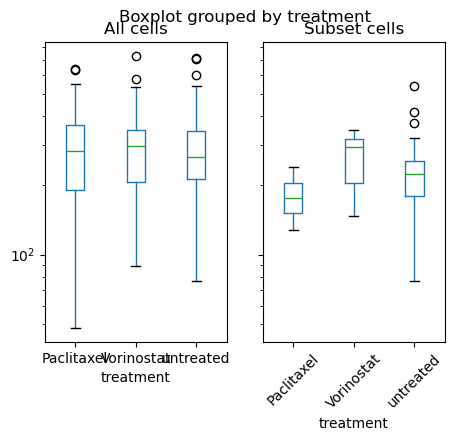

In [38]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(5,4))
value = 'Protein_nu_mean'
sc_stats[(sc_stats.Protein_name == 'ATM')].boxplot(column=value, by='treatment', grid=False, ax=ax[0])
ax[0].set_title('All cells')
#ax[0].set_xticks(['Paclitaxel', 'Vorinostat', 'untreated'], rotation=45)
sc_stats[(sc_stats.Protein_name == 'ATM') & sc_stats.PC4.isin([4,5,6]) & sc_stats.PC1.isin([4,5,6])].boxplot(column=value, by='treatment', grid=False, ax=ax[1])
#print(sc_stats[(sc_stats.Protein_name == 'JAK2') & sc_stats.PC4.isin([4,5,6]) & sc_stats.PC1.isin([0,1,2])].shape)
ax[1].set_title('Subset cells')
plt.yscale('log')   
plt.xticks(rotation=45)

/tmp/ipykernel_479830/615293957.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_479830/615293957.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning:

SeriesGroupBy.grouper is deprecated and wil

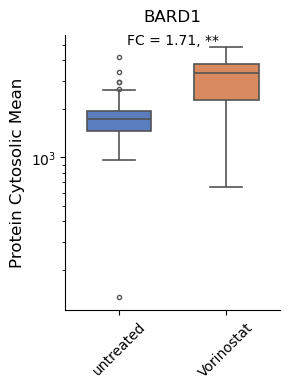

In [39]:
plt.figure(figsize=(3, 4))  # Adjust size for better visibility

protein = 'BARD1'
region = 'Protein_cyt_mean'
#tmp = sc_stats[(sc_stats.Protein_name == protein) & sc_stats.PC4.isin([4,5,6]) & sc_stats.PC1.isin([4,5,6]) & (sc_stats.treatment != 'Paclitaxel')]
tmp = sc_stats[(sc_stats.Protein_name == protein) & (sc_stats.treatment != 'Paclitaxel')]
tmp['group'] = pd.Categorical(tmp['treatment'], ordered=True, categories=['untreated', 'Vorinostat'])
#pval = stats.mannwhitneyu(tmp[tmp.group == 'untreated'][region], tmp[tmp.group == 'Paclitaxel'][region])[1]
pval = stats.ttest_ind(tmp[tmp.group == 'untreated'][region], tmp[tmp.group == 'Vorinostat'][region])[1]
fc = tmp[tmp.group == 'Vorinostat'][region].mean() / tmp[tmp.group == 'untreated'][region].mean()
# Create a boxplot with enhanced styling
sns.boxplot(
    data=tmp[['group', region]].drop_duplicates(), 
    x='group', 
    y=region, 
    palette='muted',  # Use a visually pleasing color palette
    linewidth=1.2,  # Increase line thickness for better visibility
    width=0.6,  # Control box width
    fliersize=3  # Reduce size of outliers
)
pval = 'ns' if pval > 0.05 else ('*' if pval > 0.01 else '**')
plt.annotate(f"FC = {fc:.2f}, {pval}", xy=(0.5, 0.98), xycoords='axes fraction', ha='center', va='center')
# Apply log scale to the y-axis
plt.yscale('log')

# Improve axis labels and formatting
plt.xlabel("")  # Remove x-axis label for clean look
plt.ylabel("Protein Cytosolic Mean", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
plt.title(protein, fontsize=12, pad=10)

# Remove grid for a cleaner look
sns.despine()  # Remove top and right borders

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
pval

0.06322076720548246

HPA035354_BARD1
8 /data/2Dshapespace/B2AI/raw/HPA035354_BARD1/B2AI_1_untreated_F1_R5/z01/C3.tif 6000
HPA035354_BARD1
6 /data/2Dshapespace/B2AI/raw/HPA035354_BARD1/B2AI_1_Vorinostat_F1_R8/z01/C3.tif 6000


HPA035354_BARD1
7 /data/2Dshapespace/B2AI/raw/HPA035354_BARD1/B2AI_1_Paclitaxel_F1_R8/z01/C3.tif 6000


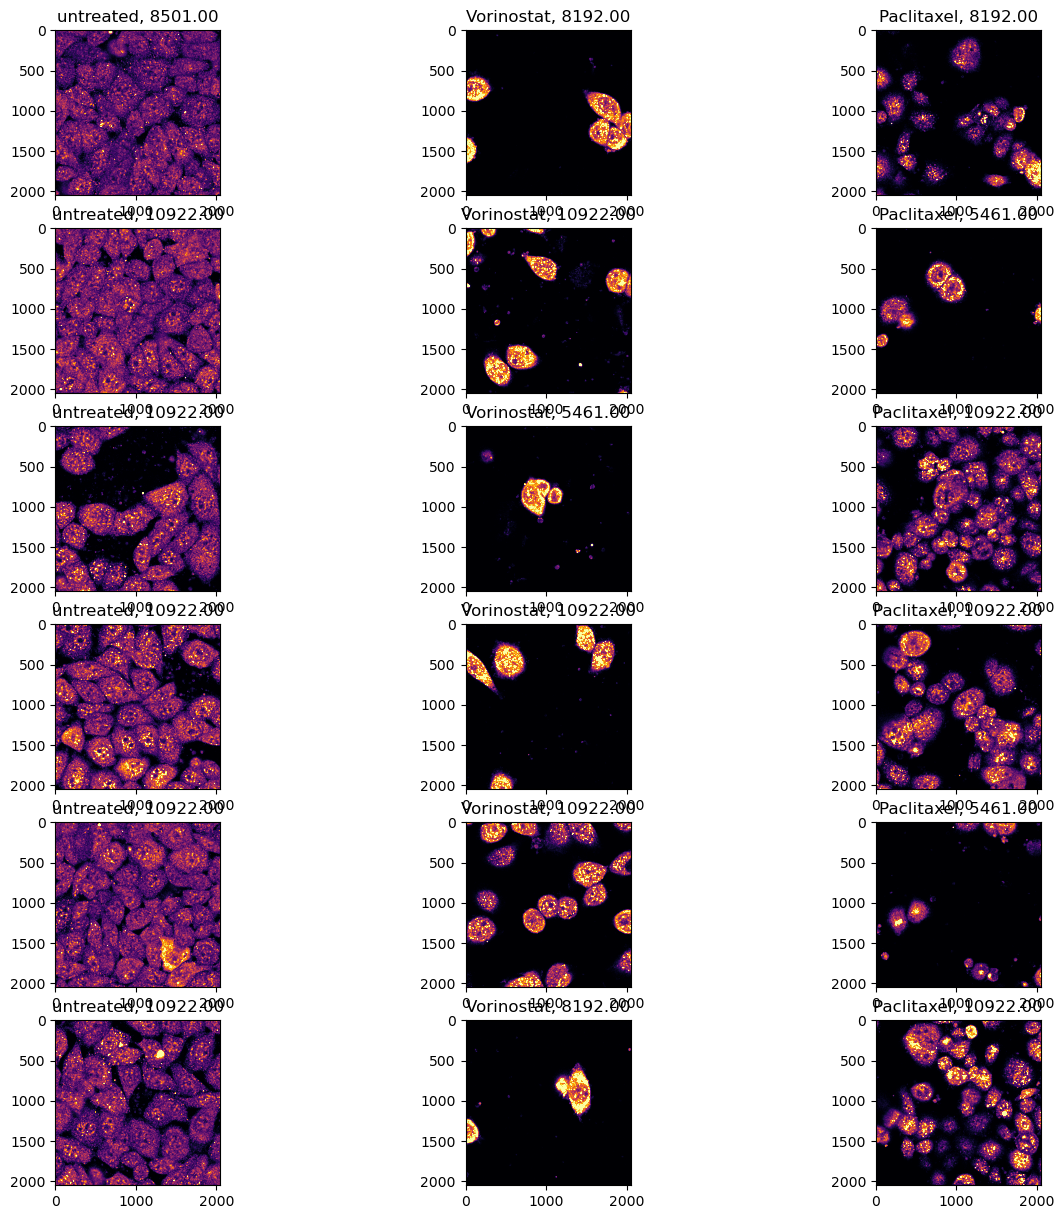

In [40]:
#plt.scatter(df_trans.PC1, df_trans.PC4)
import glob
data_dir = "/data/2Dshapespace/B2AI/raw"
#protein = "HPA046793_NEDD4"
sc_stats_protein = sc_stats[sc_stats.Protein.str.contains('BARD1')]
global_max = 6000
fig, ax = plt.subplots(6, 3, figsize=(15,15))
for i, group in enumerate(['untreated','Vorinostat','Paclitaxel']):
    df = sc_stats_protein[sc_stats_protein.treatment == group]
    print(df.Protein.values[0])
    imgs_paths = glob.glob(f'{data_dir}/{df.Protein.values[0]}/*{group[0]}*/z01/C3.tif')
    #global_max = max([np.percentile(plt.imread(img), 98) for img in imgs_paths])*0.9
    print(len(imgs_paths), imgs_paths[0], global_max)
    for j in range(6):
        img = plt.imread(imgs_paths[j]) 
        percentile99 = np.percentile(img, 99)
        ax[j, i].imshow(img, cmap='inferno', vmin=0, vmax=global_max)
        ax[j, i].set_title(f'{group}, {percentile99:.2f}')

0.2083314210176468
HPA035354_BARD1/B2AI_1_Vorinostat_F1_R1/1.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA035354_BARD1/B2AI_1_Vorinostat_F1_R1/1.npy;-94.67724737357011;(168.91752921535894, 368.1748555284448);2.459302178527068;1.6112455424245913
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA035354_BARD1/B2AI_1_Vorinostat_F1_R1/1.npy', '-94.67724737357011', '(168.91752921535894, 368.1748555284448)', '2.459302178527068', '1.6112455424245913'] -94.67724737357011
HPA035354_BARD1/B2AI_1_Vorinostat_F1_R4/12.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA035354_BARD1/B2AI_1_Vorinostat_F1_R4/12.npy;-147.88136930651385;(256.9333944139042, 318.2246099172636);2.134504110743932;2.2505425847878504
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA035354_BARD1/B2AI_1_Vorinosta

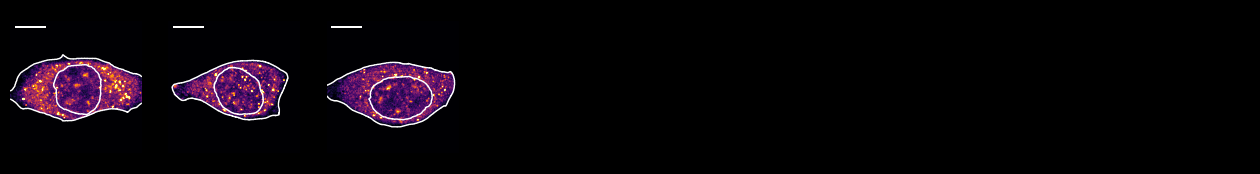

In [61]:
import sys
sys.path.append('..')
from scipy.ndimage import rotate, center_of_mass
from utils.helpers import get_line
from skimage import exposure
import configs.config as cfg

fft_shift_path = f"/data/2Dshapespace/B2AI/fftcoefs/{cfg.ALIGNMENT}/shift_error_meta_fft128.txt"
def rotate_and_pad_to_size(img, angle, final_size=(600, 600), cval=0):
    rotated = rotate(img, angle=angle, reshape=True, order=1, mode='constant', cval=cval)
    h, w = rotated.shape
    target_h, target_w = final_size

    # Pad if smaller
    pad_h = max(target_h - h, 0)
    pad_w = max(target_w - w, 0)
    rotated = np.pad(rotated,
        ((pad_h // 2, pad_h - pad_h // 2),
         (pad_w // 2, pad_w - pad_w // 2)),
        mode='constant', constant_values=cval)
    
    # Crop center if larger
    center_y, center_x = rotated.shape[0] // 2, rotated.shape[1] // 2
    final = rotated[
        center_y - target_h // 2 : center_y + target_h // 2,
        center_x - target_w // 2 : center_x + target_w // 2
    ]
    return final


def rotation_and_align(image_path, shape_path, find_pattern, rescale=False, output_size=(600, 600)):
    """Rotate and align the image based on the shift dictionary, return fixed-size outputs."""

    fft_coefs = get_line(fft_shift_path, search_text=find_pattern, mode="first")
    vals = fft_coefs.strip().split(";") 
    theta = float(vals[1])
    print(find_pattern, fft_coefs, fft_shift_path, vals, theta)

    img = plt.imread(image_path)
    if rescale:
        l, h = np.percentile(img, (0, 100))
        img = exposure.rescale_intensity(img, in_range=(l, h))

    protein_ch = rotate_and_pad_to_size(img, angle=theta, final_size=output_size)
    data = np.load(shape_path)
    nuclei = rotate_and_pad_to_size(data[1, :, :], angle=theta, final_size=output_size)
    cell = rotate_and_pad_to_size(data[0, :, :], angle=theta, final_size=output_size)

    center_cell = center_of_mass(cell)
    center_nuclei = center_of_mass(nuclei)

    if center_cell[1] > center_nuclei[1]:  # rotate 180 if flipped
        protein_ch = rotate_and_pad_to_size(protein_ch.copy(), angle=180, final_size=output_size)
        cell = rotate_and_pad_to_size(cell.copy(), angle=180, final_size=output_size)
        nuclei = rotate_and_pad_to_size(nuclei.copy(), angle=180, final_size=output_size)

    return protein_ch, nuclei, cell




pixel_size = 0.07  # μm/pixel
scale_bar_length_um = 10  # desired length in μm
scale_bar_pixels = int(scale_bar_length_um / pixel_size)
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 8, figsize=(2*8, 2))
fig.patch.set_facecolor('black')

#img_paths = sc_stats[(sc_stats.Protein_name == 'KMT2E') & (sc_stats.treatment == 'untreated') & sc_stats.PC1.isin([4,5,6]) & (sc_stats.PC4.isin([4,5,6]))].sample(frac=1).image_path.tolist()
#img_paths = sc_stats[(sc_stats.Protein_name == 'ARTD1') & (sc_stats.treatment == 'untreatPaed') & sc_stats.PC4.isin([4,5,6]) & sc_stats.PC1.isin([0,1,2])].sample(frac=1).image_path.tolist()
#img_paths = sc_stats[(sc_stats.Protein_name == 'TRIM24') & (sc_stats.treatment == 'Paclitaxel') & sc_stats.PC4.isin([0,1,2]) & sc_stats.PC1.isin([4,5,6])].image_path.tolist()

images = [plt.imread(f.replace('/scratch/users/tle1302','/data').replace('.npy','_protein.png')) for f in sc_stats[(sc_stats.Protein_name == 'BARD1') & (sc_stats.treatment.isin(['Paclitaxel','untreated'])) & sc_stats.PC1.isin([4,5,6]) & (sc_stats.PC4.isin([4,5,6]))].image_path.tolist()]
global_max = max(np.percentile(img, 99) for img in images) #* 0.9
print(global_max)
#global_max = 0.3
img_paths = sc_stats[(sc_stats.Protein_name == 'BARD1') & (sc_stats.treatment == 'Vorinostat') & sc_stats.PC1.isin([4,5,6]) & (sc_stats.PC4.isin([4,5,6]))].sample(frac=1).image_path.tolist()
#img_paths = sc_stats[(sc_stats.Protein_name == 'BARD1') & (sc_stats.treatment == 'untreated') & sc_stats.PC1.isin([4,5,6]) & (sc_stats.PC4.isin([4,5,6]))].sample(frac=1).image_path.tolist()

for i in range(8):
    try:
        imglist = img_paths #[[2,6,7,8,9]]
        imgpath = imglist[i]
        ab, sampleid, cellid = imgpath.replace('/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/', '').split('/')
        rotated_img, nuclei_mask, cell_mask = rotation_and_align(image_path=imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'),
                        shape_path=imgpath.replace('/scratch/users/tle1302','/data'),
                        find_pattern=f"{ab}/{sampleid}/{cellid}")
        #ax[0, i].imshow(img, origin='lower', cmap='inferno', vmax=np.percentile(img, 99))
        #ax[0, i].axis('off') 
        ax[i].imshow(rotated_img, origin='lower', cmap='inferno', vmin=0, vmax=global_max)
        ax[i].contour(cell_mask > 0, colors='white', linewidths=1, alpha=1)
        ax[i].contour(nuclei_mask > 0, colors='white', linewidths=1, alpha=1)
        ax[i].axis('off')
        
        # Draw white rectangle scale bar in bottom left corner
        scale_bar = Rectangle(
            (20, rotated_img.shape[0] - 30),  # x, y: start near bottom-left
            width=scale_bar_pixels,  # 10 µm in pixel units
            height=6,
            linewidth=0,
            edgecolor=None,
            facecolor='white'
        )
        ax[i].add_patch(scale_bar)
    except:
        print(f"Cluster {i} not found")
        #ax[1,i].imshow(np.zeros((128,128)), vmin=10, vmax=20)
        ax[i].axis('off')

In [ ]:
#sc_stats[sc_stats.Protein.str.contains('KDM') & ]
#sc_stats[(sc_stats.Protein_name=='PHF6') & sc_stats.PC1.isin([4,5,6])]
sc_stats

,image_path,image_name,nu_area,cell_area,cell_nu_ratio,Protein_cell_sum,Protein_nu_sum,PC1,PC2,PC3,...,PC6,PC7,PC8,treatment,Protein,Protein_cell_mean,Protein_nu_mean,Protein_cyt_mean,nucleus_inside_cell,Protein_name
0,/scratch/users/tle1302/2Dshapespace/B2AI/cell_...,1,42054,130712,3.108194,1541111672,294544996,4,1,2,...,4,1,6,Paclitaxel,CAB080431_HDAC7,11790.131526,2253.389100,14060.396986,100.0,HDAC7
2,/scratch/users/tle1302/2Dshapespace/B2AI/cell_...,3,52021,189604,3.644759,1078675933,207623408,6,3,3,...,6,1,6,untreated,CAB080431_HDAC7,5689.099033,1095.037067,6331.105769,100.0,HDAC7
3,/scratch/users/tle1302/2Dshapespace/B2AI/cell_...,1,28398,115977,4.083985,642519480,126136947,5,3,0,...,5,0,1,untreated,CAB080431_HDAC7,5540.059495,1087.603120,5896.191244,100.0,HDAC7
4,/scratch/users/tle1302/2Dshapespace/B2AI/cell_...,2,22173,61902,2.791774,345370221,90725102,3,4,6,...,3,4,3,untreated,CAB080431_HDAC7,5579.306339,1465.624729,6409.552695,100.0,HDAC7
5,/scratch/users/tle1302/2Dshapespace/B2AI/cell_...,8,43340,157443,3.632741,1337232125,228690618,6,6,0,...,5,2,3,untreated,CAB080431_HDAC7,8493.436514,1452.529601,9715.270475,100.0,HDAC7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31240,/scratch/users/tle1302/2Dshapespace/B2AI/cell_...,6,31926,102261,3.203063,507871484,179198142,4,4,0,...,3,0,6,untreated,HPA030991_HDAC5,4966.423994,1752.360548,4672.969958,100.0,HDAC5
31241,/scratch/users/tle1302/2Dshapespace/B2AI/cell_...,9,31960,95194,2.978536,382575479,155020360,3,1,1,...,6,2,2,untreated,HPA030991_HDAC5,4018.903282,1628.467761,3598.619714,100.0,HDAC5
31242,/scratch/users/tle1302/2Dshapespace/B2AI/cell_...,28,23099,56161,2.431317,308728953,137489071,2,5,4,...,5,3,2,untreated,HPA030991_HDAC5,5497.212532,2448.123627,5179.356421,100.0,HDAC5
31243,/scratch/users/tle1302/2Dshapespace/B2AI/cell_...,23,29745,81558,2.741906,508000614,229487909,3,4,6,...,4,3,2,untreated,HPA030991_HDAC5,6228.703671,2813.800105,5375.344122,100.0,HDAC5
